In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2

seed = 0
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
device = torch.device('cpu')

In [3]:
!pwd

/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook


In [4]:
image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/classification/ISIC_2019_Training_Input/'

In [5]:
train = pd.read_csv('/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/train.csv')
train

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,...,sex_index,age_index,anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity
0,ISIC_0033863,65.0,posterior torso,HAM_0007086,female,1.0,0.0,0.0,0.0,0.0,...,0,0.65,0,0,0,0,0,0,1,0
1,ISIC_0032707,55.0,posterior torso,HAM_0007124,male,0.0,1.0,0.0,0.0,0.0,...,1,0.55,0,0,0,0,0,0,1,0
2,ISIC_0026033,60.0,lower extremity,HAM_0003319,female,0.0,1.0,0.0,0.0,0.0,...,0,0.60,0,0,0,1,0,0,0,0
3,ISIC_0033913,75.0,posterior torso,HAM_0001855,male,0.0,0.0,0.0,0.0,1.0,...,1,0.75,0,0,0,0,0,0,1,0
4,ISIC_0033740,25.0,head/neck,HAM_0005997,female,0.0,1.0,0.0,0.0,0.0,...,0,0.25,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15194,ISIC_0011140,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,...,0,0.60,0,0,0,0,0,0,0,1
15195,ISIC_0026940,75.0,lower extremity,HAM_0005973,male,0.0,0.0,1.0,0.0,0.0,...,1,0.75,0,0,0,1,0,0,0,0
15196,ISIC_0066907,45.0,lower extremity,BCN_0000761,male,1.0,0.0,0.0,0.0,0.0,...,1,0.45,0,0,0,1,0,0,0,0
15197,ISIC_0069691,35.0,upper extremity,BCN_0001737,male,0.0,1.0,0.0,0.0,0.0,...,1,0.35,0,0,0,0,0,0,0,1


In [6]:
train.loc[15196][['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']].values.astype('float')


array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
train.loc[15196][['sex_index','age_index','anterior torso', 'head/neck', 'lateral torso', 'lower extremity',\
                  'oral/genital', 'palms/soles', 'posterior torso', 'upper extremity']].values.astype('float')

array([1.  , 0.45, 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ])

In [8]:
train.columns

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex', 'MEL',
       'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'sex_index',
       'age_index', 'anterior torso', 'head/neck', 'lateral torso',
       'lower extremity', 'oral/genital', 'palms/soles', 'posterior torso',
       'upper extremity'],
      dtype='object')

## Load sample

In [9]:
train.loc[0,'image']

'ISIC_0033863'

<class 'numpy.ndarray'>


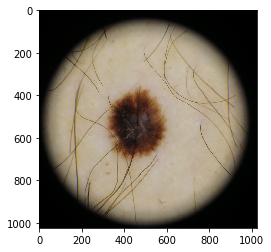

In [10]:
sample_path = image_path+train.loc[15196,'image']+'.jpg'
#sample = Image.open(sample_path)
sample = cv2.imread(sample_path)
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
print(type(sample))
plt.imshow(sample)

In [11]:
ToTensor()(sample).size()

torch.Size([3, 1024, 1024])

## Crop black edge

In [12]:
def change_size(image):
    #image=cv2.imread(read_file,1) #读取图片 image_name应该是变量
    img = cv2.medianBlur(image,5) #中值滤波，去除黑色边际中可能含有的噪声干扰
    b=cv2.threshold(img,15,255,cv2.THRESH_BINARY)          #调整裁剪效果
    binary_image=b[1]               #二值图--具有三通道
    binary_image=cv2.cvtColor(binary_image,cv2.COLOR_BGR2GRAY)
    print(binary_image.shape)       #改为单通道
 
    x=binary_image.shape[0]
    #print("高度x=",x)
    y=binary_image.shape[1]
    #print("宽度y=",y)
    edges_x=[]
    edges_y=[]
    for i in range(x):
        for j in range(y):
            if binary_image[i][j]==255:
                edges_x.append(i)
                edges_y.append(j)
 
    left=min(edges_x)               #左边界
    right=max(edges_x)              #右边界
    width=right-left                #宽度
    bottom=min(edges_y)             #底部
    top=max(edges_y)                #顶部
    height=top-bottom               #高度
 
    pre1_picture=image[left:left+width,bottom:bottom+height]        #图片截取
    print(pre1_picture.shape[:2])
    return pre1_picture                                             #返回图片数据
        

(1024, 1024)
(978, 974)


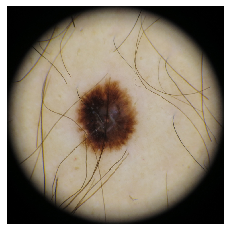

In [13]:
sample_crop = change_size(sample)
plt.imshow(sample_crop);
plt.axis('off');

## Shades of Gray color constancy

In [14]:
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

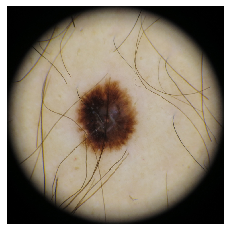

In [15]:
plt.imshow(sample_crop);
plt.axis('off');

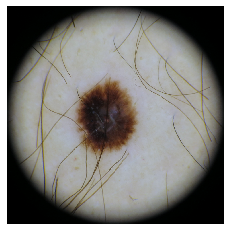

In [16]:
sample_crop = shade_of_gray_cc(sample_crop)
plt.imshow(shade_of_gray_cc(sample_crop));
plt.axis('off');

## Resize to (512xN), 512 for shorter edge

In [17]:
sample_crop.shape

(978, 974, 3)

In [18]:
target_size = 512
resize_ratio = 512/min(sample_crop.shape[0],sample_crop.shape[1])
resize_ratio

0.5256673511293635

In [19]:
cv2.resize(sample_crop,dsize=None,fx=resize_ratio,fy=resize_ratio,interpolation=cv2.INTER_AREA).shape

(514, 512, 3)

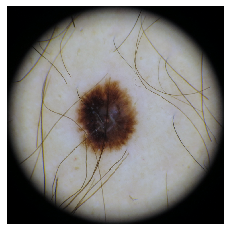

In [20]:
plt.imshow(sample_crop);
plt.axis('off');

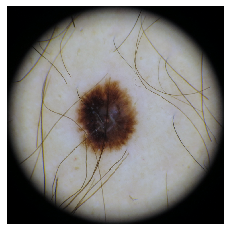

In [21]:
sample_resize = cv2.resize(sample_crop,dsize=None,fx=resize_ratio,fy=resize_ratio,interpolation=cv2.INTER_AREA)
plt.imshow(sample_crop);
plt.axis('off');

## Data Augmentation

In [22]:
train_test_normalize = transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052])

In [40]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomVerticalFlip())
transforms.RandomRotation(180, expand=True)
#train_transform.transforms.append(transforms.RandomCrop(380, padding=0))
train_transform.transforms.append(transforms.RandomResizedCrop(380, scale=(0.08, 1.0), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(train_test_normalize)
train_transform.transforms.append(transforms.RandomErasing())

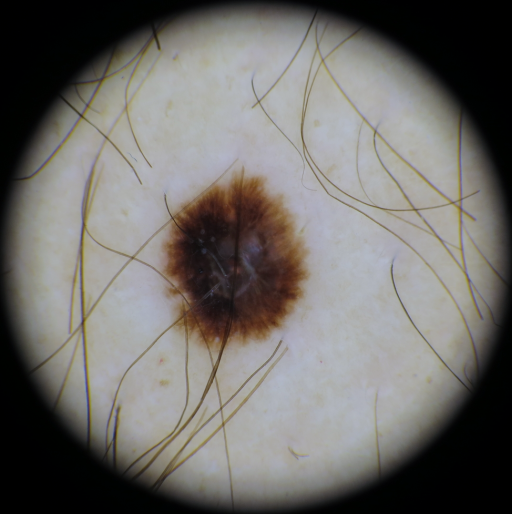

In [27]:
PIL_image = Image.fromarray(sample_resize, 'RGB')
PIL_image

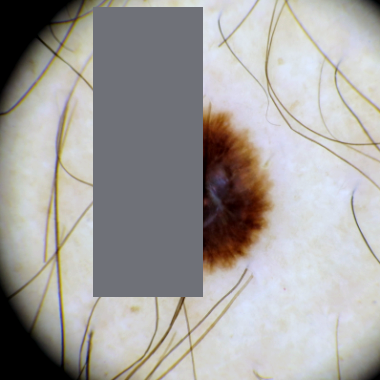

In [43]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(train_transform(PIL_image))
transforms.ToPILImage()(image)